# Problem Set 4

In [7]:
# imports
import numpy as np
from scipy.ndimage import uniform_filter1d
from scipy.stats import shapiro, bartlett
from matplotlib import pyplot as plt
import pandas

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf

In [8]:
def set_fontsize(ax,fsz):
    """
    Set the fontsize throughout an Axis
    
    Args:
        ax (Matplotlib Axis): 
        fsz (float): Font size

    Returns:

    """
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fsz)


# Question 1 -- Fit a broken line to SST

## Load data

In [15]:
SIO_file = '../Data/SIO_SST.txt'
SIO_df = pandas.read_table(SIO_file, delim_whitespace=True)
SIO_df.head()

,year,SST
0,1916,15.642
1,1917,16.743
2,1918,17.385
3,1919,16.810
4,1920,16.576


## Dates

In [16]:
dates = []
for index, row in SIO_df.iterrows():
    dates.append(f'{int(row.year)}')
dates = pandas.to_datetime(dates)
SIO_df['date'] = dates
SIO_df.set_index('date', inplace=True)
# Remove Year
SIO_df.drop(columns='year', inplace=True)
SIO_df.head()

,SST
date,
1916-01-01,15.642
1917-01-01,16.743
1918-01-01,17.385
1919-01-01,16.810
1920-01-01,16.576


## Prep for fitting

In [17]:
data = pandas.DataFrame()
data['SST'] = SIO_df.SST.values
data.index = SIO_df.index

In [18]:
dummy0 = np.zeros(len(data))
dummy0[data.index >= pandas.to_datetime('1989')] = 1
data['dummy0'] = dummy0
data.dummy0[-40:-30]

date
1981-01-01    0.0
1982-01-01    0.0
1983-01-01    0.0
1984-01-01    0.0
1985-01-01    0.0
1986-01-01    0.0
1987-01-01    0.0
1988-01-01    0.0
1989-01-01    1.0
1990-01-01    1.0
Name: dummy0, dtype: float64

## Fit

In [19]:
dummy0_formula = "SST ~ dummy0"
mod_dummy0 = smf.glm(formula=dummy0_formula, data=data).fit()#, family=sm.f
mod_dummy0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    SST   No. Observations:                  105
Model:                            GLM   Df Residuals:                      103
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                         0.41249
Method:                          IRLS   Log-Likelihood:                -101.49
Date:                Wed, 04 May 2022   Deviance:                       42.487
Time:                        11:49:05   Pearson chi2:                     42.5
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4625
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.9302      0.075    225.224      0.000      16.783      17.078
dummy0         1.0992      0.136      8.073      0.000       0.832       1.366
==============================================================================
"""

In [20]:
data['dummy_model'] = mod_dummy0.fittedvalues

## Plot

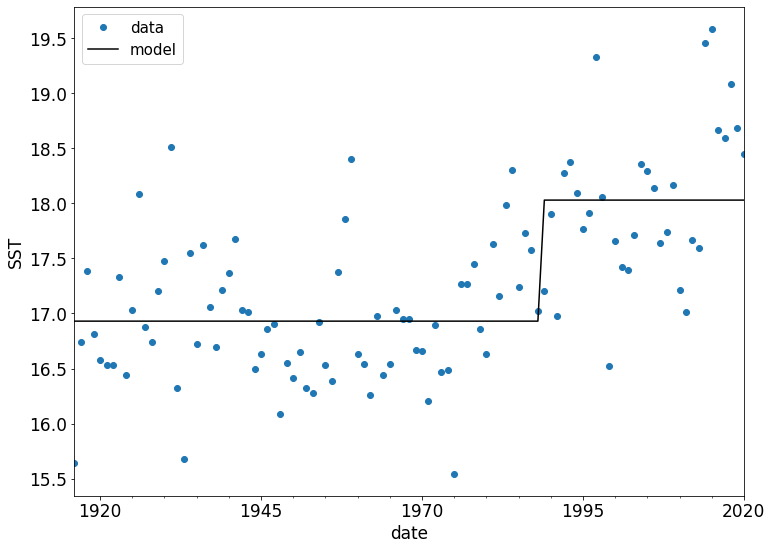

In [21]:
fig = plt.figure()
fig.set_size_inches((12, 9))
ax = data.SST.plot(ylabel='SST', label='data', marker='o', ls='')
#
data.dummy_model.plot(ax=ax, color='k', label='model')
#
ax.legend(fontsize=15)
#
set_fontsize(ax, 17)
plt.savefig('PS4_Q1.png', dpi=300)

# Question 2

In [22]:
data['adjSST'] = data.SST.values - data.dummy_model.values

## Plot

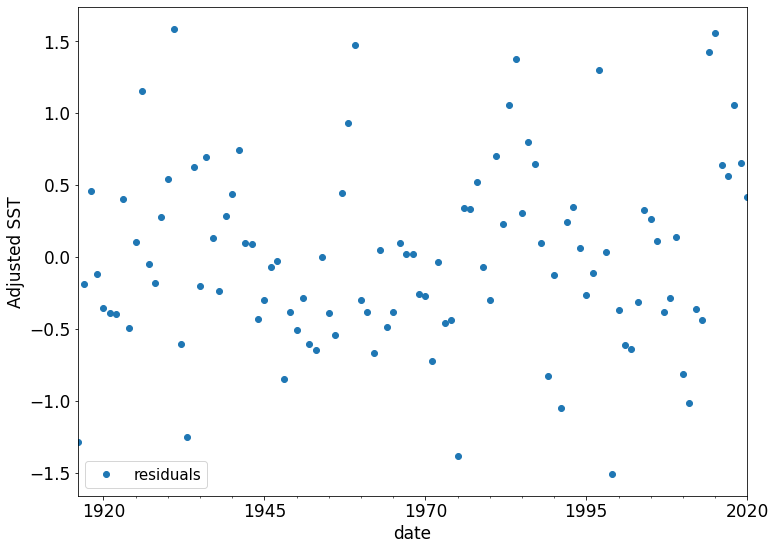

In [23]:
fig = plt.figure()
fig.set_size_inches((12, 9))
ax = data.adjSST.plot(ylabel='Adjusted SST', label='residuals', marker='o', ls='')
#
ax.legend(fontsize=15)
#
set_fontsize(ax, 17)
plt.savefig('PS4_Q2.png', dpi=300)

# Question 3 -- Autocorrelation of Adjusted SST

## Plot

<Figure size 432x288 with 0 Axes>

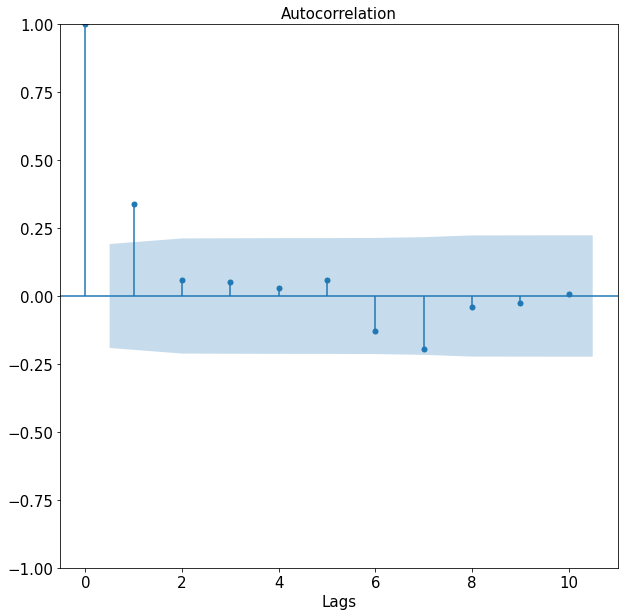

In [24]:
plt.clf()
fig=plt.figure(figsize=(10,10))
ax=plt.gca()
fig = plot_acf(data.adjSST.values, lags=10, ax=ax)
#
set_fontsize(ax,15)
ax.set_xlabel('Lags')
plt.savefig('PS4_Q3.png', dpi=300)

# Question 4 -- PACF

/home/xavier/Projects/miniconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

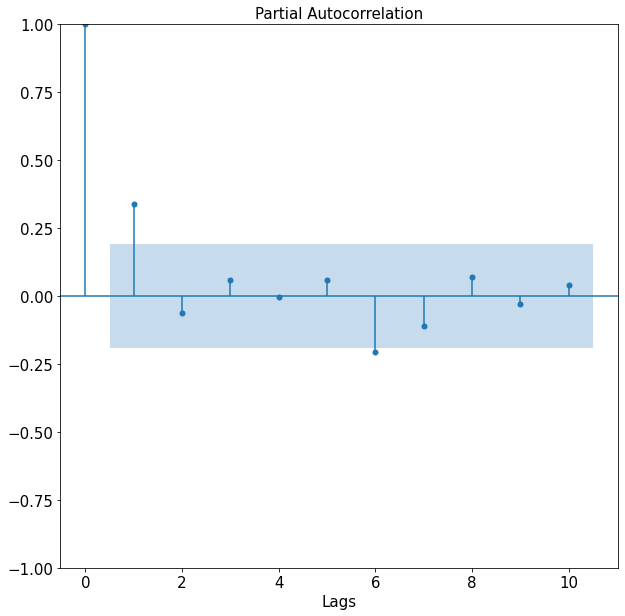

In [25]:
plt.clf()
fig=plt.figure(figsize=(10,10))
ax=plt.gca()
fig = plot_pacf(data.adjSST.values, lags=10, ax=ax)
#
set_fontsize(ax,15)
ax.set_xlabel('Lags')
plt.savefig('PS4_Q4.png', dpi=300)

# Question 5 -- What lag?

## The lag=1 is statistically significant, but none other (we may ignore Lag=6 in the PACF)

----

# Question 6 -- PACF values

In [26]:
pacf_v, confint = pacf(data.adjSST.values, nlags=10, alpha=0.05)

In [27]:
pacf_v

array([ 1.        ,  0.34008319, -0.06104965,  0.05782297, -0.00476113,
        0.05930001, -0.2054211 , -0.10868448,  0.06995459, -0.02957962,
        0.03928702])

## PACF for Lag = 1 is  0.340

----

# Question 7 -- Fit with AR(1)

## Fit

In [38]:
glsar_model_1 = sm.GLSAR(data.SST, data.dummy0, 1)
glsar_results_1 = glsar_model_1.iterative_fit(maxiter=50)
print(glsar_results_1.summary())


                                GLSAR Regression Results                               
Dep. Variable:                    SST   R-squared (uncentered):                   0.019
Model:                          GLSAR   Adj. R-squared (uncentered):              0.009
Method:                 Least Squares   F-statistic:                              1.997
Date:                Wed, 04 May 2022   Prob (F-statistic):                       0.161
Time:                        11:55:44   Log-Likelihood:                         -136.23
No. Observations:                 104   AIC:                                      274.5
Df Residuals:                     103   BIC:                                      277.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## AIC = 274.5

----

# Question 8 -- AR(15) !!

In [39]:
glsar_model_15 = sm.GLSAR(data.SST, data.dummy0, rho=15)
glsar_results_15 = glsar_model_15.iterative_fit(maxiter=50)
print(glsar_results_15.summary())

                                GLSAR Regression Results                               
Dep. Variable:                    SST   R-squared (uncentered):                   0.089
Model:                          GLSAR   Adj. R-squared (uncentered):              0.079
Method:                 Least Squares   F-statistic:                              8.688
Date:                Wed, 04 May 2022   Prob (F-statistic):                     0.00409
Time:                        11:56:10   Log-Likelihood:                         -140.64
No. Observations:                  90   AIC:                                      283.3
Df Residuals:                      89   BIC:                                      285.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## AIC = 283.3

----

# Question 8.5 -- Examine PACF

/home/xavier/Projects/miniconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


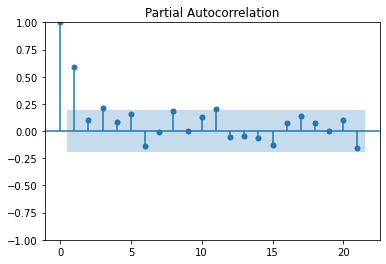

In [35]:
_ = plot_pacf(data.SST)